In [2]:
# Загружаем библиотеки, которые могут понадобиться

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
import math

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Знакомство с датасетом
Загрузим датасет представленный на kaggle, посмотрим на формат признаков и количество пропусков.

In [5]:
#DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission (1).csv')

# Описание признаков:

client_id - идентификатор клиента

education - уровень образования (SCH-школа, UGR-бакалавр, GRD-магистр, PGR-кандидат наук, ACD-доктор наук)

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

В датасете 19 признаков, из которых 6 не числовые. Пропуски есть только в одном столбце "education" и то не много, меньше 1%. Далее попробуем сразу построить примитивную модель на основании признаков без какой либо обработки, чтобы иметь ориентир для улучшения.

# Построение примитивной модели
Попробуем построить первую модель на основе числовых признаков в датасете и посмотрим на значение метрик.

In [7]:
df.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


In [8]:
# Создадим список из всех числовых признаков, кроме 'client_id' т.к. он точно не содержит полезной информации для модели
numeric_cols = ['age', 'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
                'region_rating', 'home_address', 'work_address', 'income', 'sna', 'first_time']

## Функции для анализа метрик


Основные метрики на которые будем опираться:


Confusion matrix: матрица значений, показывающая сколько клиентов наша модель определила верно и не верно, в натуральных и относительных величинах.


ROC-AUC-кривая: показывает точность модели в целом.


f1_score: показывает насколько точно наша модель определяет дефолтных клиентов.


recall: показывает какую долю из всех дефолтных клиентов нашла наша модель


In [9]:
def plot_cmatrix(y, y_pred):
    """построение confusion матрицы в абсолютных и нормализованных значениях
    """
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    labels = [0, 1]
    cm = confusion_matrix(y, y_pred, labels=labels)
    cm_norm = confusion_matrix(y, y_pred, labels=labels, normalize="all")
    # cm_norm = confusion_matrix(y, y_pred, labels=labels, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp.plot(ax=axes[0])
    disp_norm.plot(ax=axes[1])
    plt.show()


def print_metrics(y_true, y_pred):
    """вывод метрик
    """
    print(f"accuracy: {round(accuracy_score(y_true,y_pred), 3)}")
    print(f"precision: {round(precision_score(y_true,y_pred), 3)}")
    print(f"recall: {round(recall_score(y_true,y_pred), 3)}")
    print(f"f1: {round(f1_score(y_true,y_pred), 3)}")


def roc_auc(y_test, y_proba):
    probs = y_proba[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
# Определяем целевую и зависимую переменные
X = df[numeric_cols].values
Y = df['default'].values

In [11]:
# Разбиваем выборку на тренировочную и валидационную
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

Построим модель и оценим метрики

In [12]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

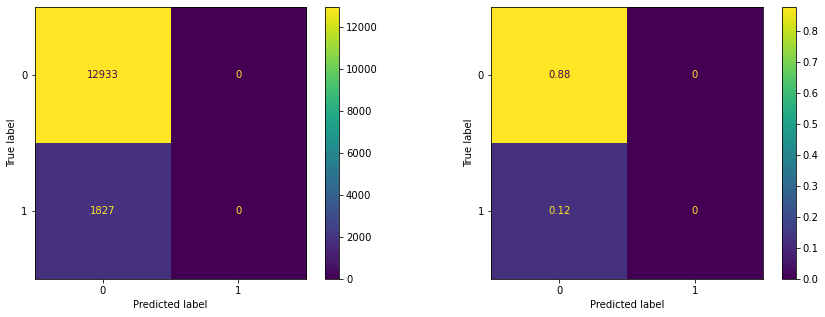

accuracy: 0.876
precision: 0.0
recall: 0.0
f1: 0.0


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
confusion_matrix(y_test, y_pred, labels=[1, 0])
plot_cmatrix(y_test, y_pred)
print_metrics(y_test, y_pred)

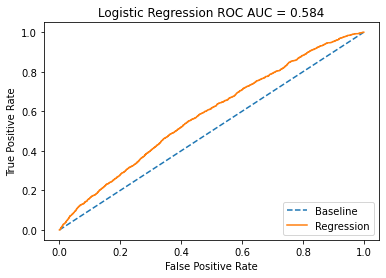

In [14]:
roc_auc(y_test, y_proba)

Как видим без предварительной обработки модель совсем плоха: всех клиентов считает не дефолтными. Такая модель нам точно не подходит. 




Проведем разведывательный анализ данных, обработаем категориальные признаки, поработаем с распределением, построим графики.

# EDA

Посмотрим внимательнее на наши данные и разделим признаки на 3 категории: бинарные, категориальные и числовые.

In [15]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address',
            'work_address', 'sna', 'first_time', 'app_date']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'region_rating']

Теперь бинарные и категориальные признаки, представленные не числами, преобразуем в числовой формат чтобы модель могла с ними работать.

In [16]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

# убедимся в преобразовании
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


В списке категориальных признаков есть один признак с пропусками: education. Перед преобразованием его в числовой формат нужно заполнить пропуски. Пропуски заполним самым популярным значением 'SCH'. Кроме того что это значение является модой, берем в расчет что как минимум школьное образование должно быть у каждого клиента.

In [17]:
# Заполним пропуски самым популярным типом образования среди клиентов
df['education'].fillna(df['education'].value_counts().index[0], inplace=True)
df_test['education'].fillna(
    df_test['education'].value_counts().index[0], inplace=True)

Далее преобразуем признак в формат чисел

In [18]:
def education_to_num(x):
    '''Функция для преобразования уровня образования клентов в числовой формат'''

    if x == 'SCH':
        return 1
    elif x == 'UGR':
        return 2
    elif x == 'GRD':
        return 3
    elif x == 'PGR':
        return 4
    elif x == 'ACD':
        return 5
    else:
        return 6

In [19]:
df['education'] = df['education'].apply(education_to_num)
df_test['education'] = df_test['education'].apply(education_to_num)

Теперь обработаем признак отвечающий за дату подачи заявки. Посмотрим на месяцы и дни подачи заявок.

In [20]:
# преобразуем значение в dt формат
df['app_date'] = pd.to_datetime(df['app_date'], format="%d%b%Y")
df_test['app_date'] = pd.to_datetime(df_test['app_date'], format="%d%b%Y")

# посмотрим, какие месяцы и дни есть в выборке
print(df['app_date'].dt.month.value_counts())
print(df['app_date'].dt.weekday.value_counts())
print(df['app_date'].dt.year.value_counts())

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64
1    12176
0    12024
2    11740
3    11615
4    11263
5     8231
6     6750
Name: app_date, dtype: int64
2014    73799
Name: app_date, dtype: int64


Видим что выборка только за 4 месяца 2014 года. Заявки подавались во все дни недели, заметно только что по выходным заявок меньше в среднем на 30%. Посмотрим пригодится ли нам эта информация.

In [21]:
# вместо признака с датой создадим два новых, с месяцем и днем подачи заявки
df['month'] = df['app_date'].dt.month
df_test['month'] = df_test['app_date'].dt.month
df['day'] = df['app_date'].dt.weekday
df_test['day'] = df_test['app_date'].dt.weekday

In [22]:
# Добавим новые признаки в список категориальных признаков, и уберем оттуда признак даты
cat_cols = cat_cols+['month', 'day']
cat_cols.remove('app_date')

Теперь все признаки преобразованы в числовой формат. Можем посмотреть как они распределены на графиках.

## Графики

Посмотрим на числовые признаки на графиках

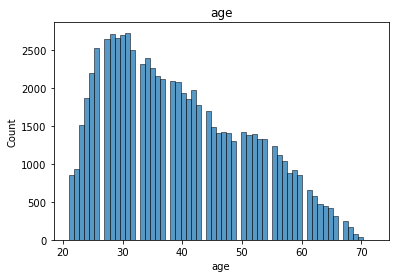

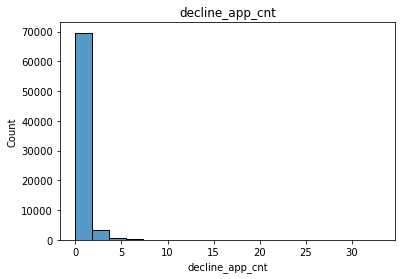

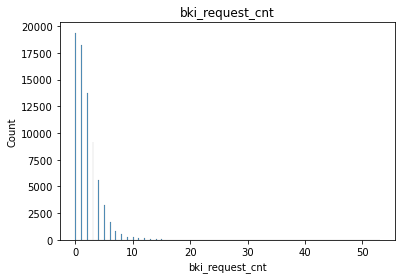

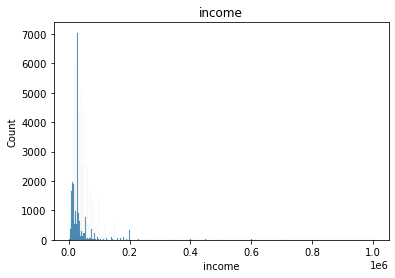

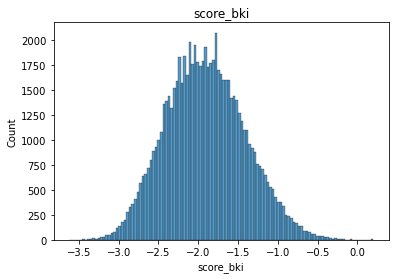

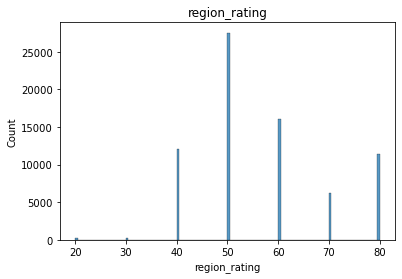

In [23]:
for i in num_cols:
    plt.figure()
    sns.histplot(df[i].dropna(), kde=False)
    plt.title(i)
    plt.show()

Видим, что часть признаков имеют большой правый хвост на графиках. А некоторые имеют слишком большие значения относительно других. Попробуем прологарифмировать чтобы распределение стало более нормальным. Также сделаем обработку рейтинга, чтобы не работать с отрицательными величинами.

In [24]:
# Преобразуем рейтинг в положительные величины
df['score_bki'] = np.sqrt(df['score_bki']**2)
df_test['score_bki'] = np.sqrt(df_test['score_bki']**2)

In [25]:
for i in num_cols:
    df[i+'_log'] = df[i].apply(lambda x: np.log(x) if x > 0 else x)
    df_test[i+'_log'] = df_test[i].apply(lambda x: np.log(x) if x > 0 else x)

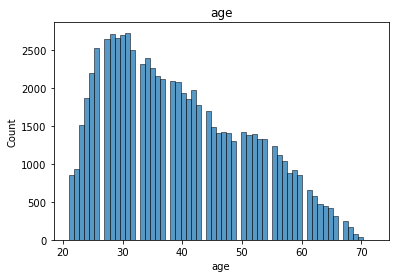

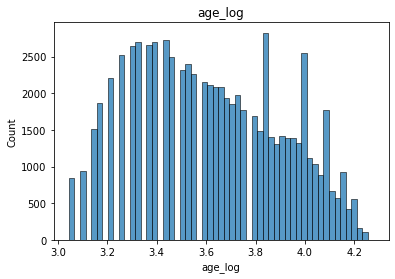

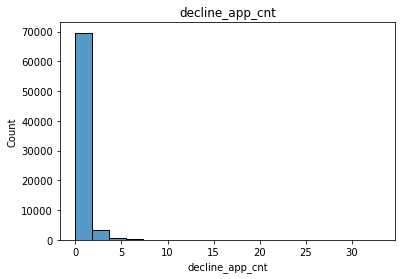

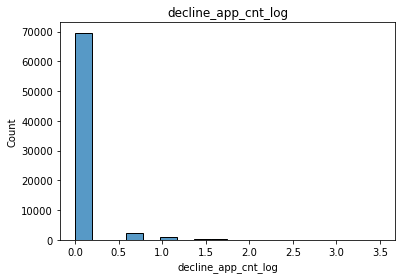

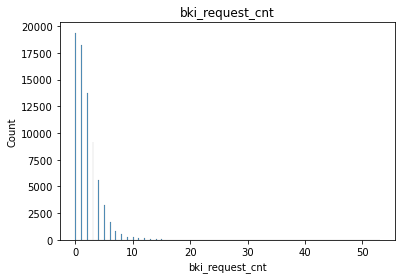

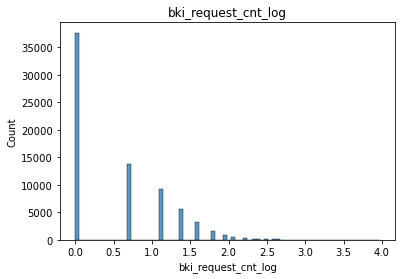

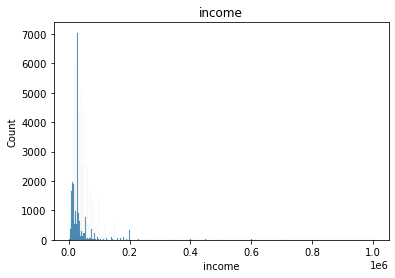

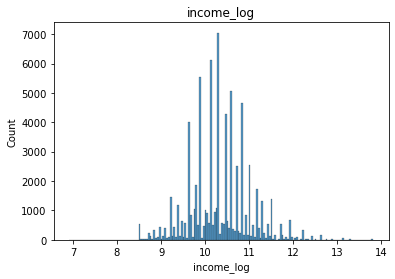

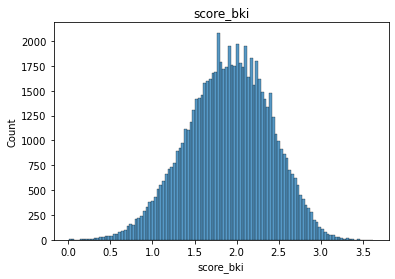

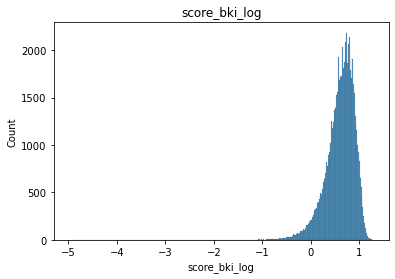

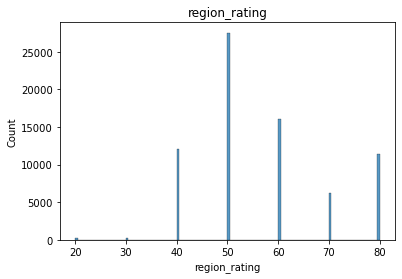

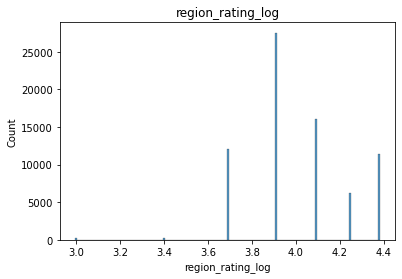

In [26]:
for i in num_cols:
    plt.figure()
    sns.histplot(df[i].dropna(), kde=False)
    plt.title(i)
    plt.show()
    plt.figure()
    sns.histplot(df[i+'_log'].dropna(), kde=False)
    plt.title(i+'_log')
    plt.show()

После логарифмирования разница в значениях стала заметно меньше. Правые хвосты у некоторых признаков тоже заметно сократились.Заметно, что по переменной decline_app_cnt подавляющее большинство клиентов имеет показатель 0, а значение больше 5 имеют только исключительные клиенты.
Похожая ситуация и с признаком bki_request_cnt. Посмотрим на два этих признака внимательнее...

In [27]:
df['decline_app_cnt'].value_counts().head(7)

0    61214
1     8397
2     2468
3      903
4      414
5      165
6      113
Name: decline_app_cnt, dtype: int64

In [28]:
df['bki_request_cnt'].value_counts().head(7)

0    19381
1    18276
2    13749
3     9187
4     5627
5     3268
6     1704
Name: bki_request_cnt, dtype: int64

На основании этих данных можно сформировать новые признаки, показывающие наличие хоть одного отказа по признаку decline_app_cnt, и наличие более 3-ёх заявок по признаку bki_request_cnt.


In [29]:
df['decline_more0'] = df['decline_app_cnt'].apply(lambda x: 1 if x > 0 else 0)
df_test['decline_more0'] = df_test['decline_app_cnt'].apply(
    lambda x: 1 if x > 0 else 0)

In [30]:
def amount_request_bki(x):
    '''Функция для распределения категорий клиентов по количеству заявок'''
    if x == 0:
        return 1
    elif 3 >= x >= 1:
        return 2
    else:
        return 3

In [31]:
# Создадим категориальный признак по колличеству заявок клиентов
df['bki_request_amt'] = df['bki_request_cnt'].apply(amount_request_bki)
df_test['bki_request_amt'] = df_test['bki_request_cnt'].apply(
    amount_request_bki)
# Добавим еще бинарный признак обозначающий клиентов с большим кол-вом заявок
df['many_requests'] = df['bki_request_cnt'].apply(lambda x: 1 if x > 5 else 0)
df_test['many_requests'] = df_test['bki_request_cnt'].apply(
    lambda x: 1 if x > 5 else 0)

Далее попробуем распределить клиентов по возрастным группам, для лучшей структуризации.

In [32]:
def age_categories(x):
    if x < 18:
        return 0
    elif 27 >= x >= 18:
        return 1
    elif 40 >= x > 27:
        return 2
    elif 55 >= x > 40:
        return 3
    else:
        return 4

In [33]:
df['age_cat'] = df['age'].apply(age_categories)
df_test['age_cat'] = df_test['age'].apply(age_categories)

In [34]:
# Добавляем все новые признаки в соответствующие списки
num_cols.append('age_log')
num_cols.append('decline_app_cnt_log')
num_cols.append('bki_request_cnt_log')
num_cols.append('income_log')
num_cols.append('score_bki_log')
num_cols.append('region_rating_log')
bin_cols.append('decline_more0')
bin_cols.append('many_requests')
cat_cols.append('bki_request_amt')
cat_cols.append('age_cat')

Теперь построим графики для категориальных признаков:

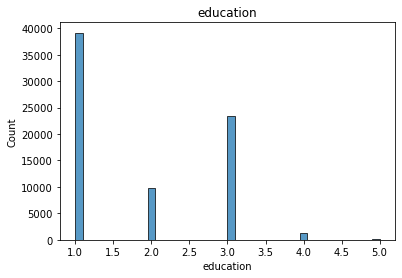

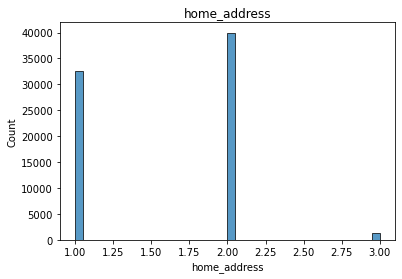

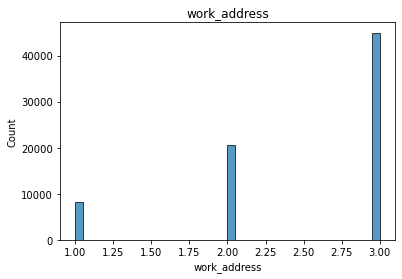

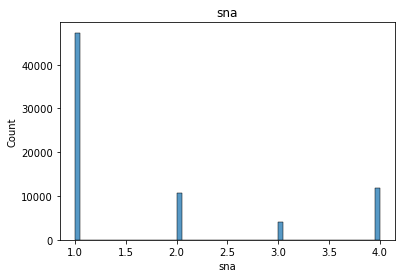

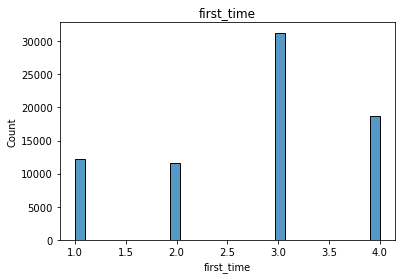

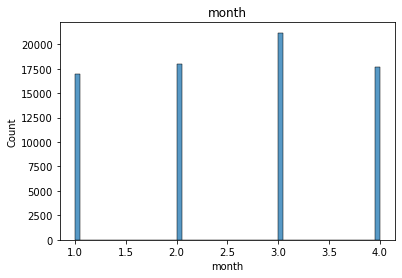

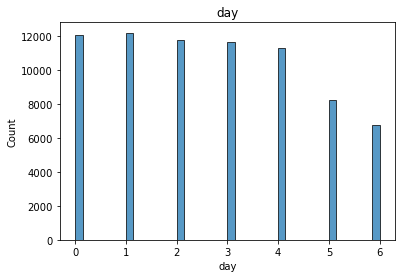

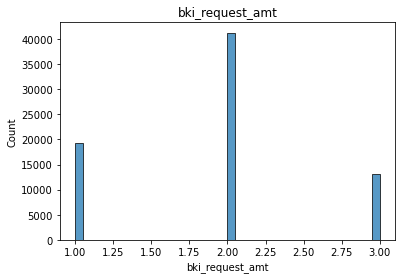

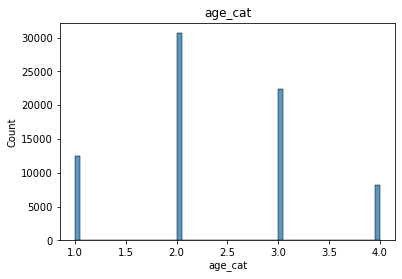

In [35]:
for i in cat_cols:
    plt.figure()
    sns.histplot(df[i].dropna(), kde=False)
    plt.title(i)
    plt.show()

В целом распределение более-менее нормальное. Бросается в глаза только крайне малое кол-во клиентов с показателем 3 признака home_address. Думаю из этого можно сделать бинарный признак, возможно данные клиенты из неблагополучного района.

In [36]:
df['bad_address'] = df['home_address'].apply(lambda x: 1 if x == 3 else 0)

In [37]:
# Добавим новый признак в соответствующий список
bin_cols.append('bad_address')

Далее оценим влияние признаков на целевую переменную

## Влияние числовых признаков

<AxesSubplot:>

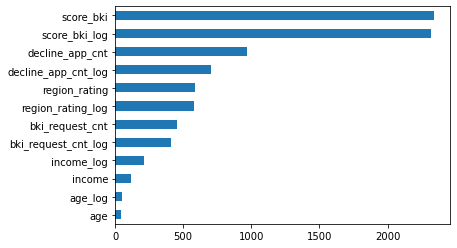

In [38]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Видим что наименее влиятельным признаком является возраст, возможно в итоговой модели от этого признака можно будет отказаться, как и от его логарифмированной версии.

## Влияние категориальных признаков

Влияние категориальных признаков будем оценивать вместе с бинарными.

<AxesSubplot:>

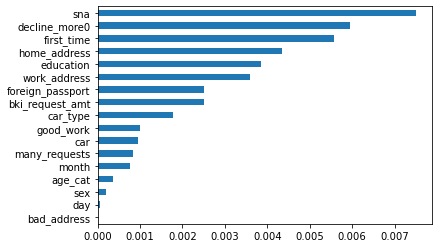

In [39]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Как видим признак адреса жительства на целевую переменную влияния не оказывает. Можно его убрать из модели.

In [40]:
bin_cols.remove('bad_address')

# Создание модели

Окончательно подготовим данные к загрузке в модель. Для это создадим из все категориальных признаков dummy-переменные.

In [41]:
X_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_cols].values)
X_cat_test = OneHotEncoder(sparse=False).fit_transform(
    df_test[cat_cols].values)

Стандартизируем наши числовые признаки

In [42]:
X_num = StandardScaler().fit_transform(df[num_cols].values)
X_num_test = StandardScaler().fit_transform(df_test[num_cols].values)

Создаем матрицу из всех обработаных признаков в переменную Х. В переменную Y определяем массив из целевых значений.

In [43]:
X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [44]:
# Также отдельно собрали все признаки тестовой выборки, которые будут использоваться для предсказания submission
X_df_test = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

Делим выборку на трейн и тест, в пропорции 80/20 и фиксируем random_state=42.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

Создаем модель, смотрим метрики.

In [47]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

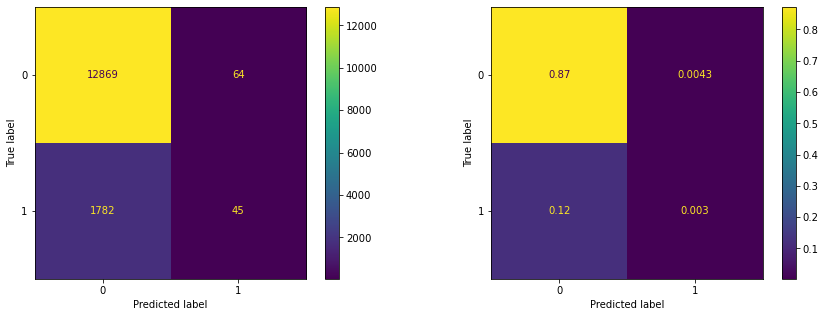

accuracy: 0.875
precision: 0.413
recall: 0.025
f1: 0.046


In [48]:
confusion_matrix(y_test, y_pred, labels=[1, 0])
plot_cmatrix(y_test, y_pred)
print_metrics(y_test, y_pred)

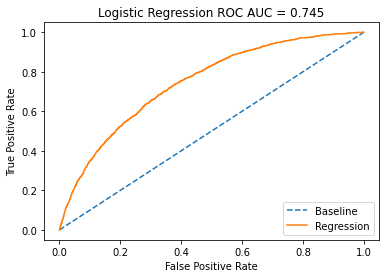

In [49]:
roc_auc(y_test, y_proba)

По сравнению с начальной примитивной моделью показатели заметно улучшились. Теперь наша модель уже находит часть дефолтных клиентов, однако ошибка второго рода все еще слишком велика, модель находит слишком мало дефолтных клиентов. Для банка такая модель будет малоэффективна.

Попробуем поработать с гиперпараметрами, чтобы добиться лучшего распознавания дефолтных клиентов (показатели recall и f1_score) и при этом не потерять общего качества модели (ROC-AUC).

# Гиперпараметры

В гиперпараметрах добавим балансировку в разделении по классам, а также посмотрим какой лучше использовать коэффициент в регуляризации и какой алгоритм лучше справится с задачей.

Поиск оптимальных гиперпараметров проведем с использованием GridSearchCV. Ориентиром для оценки будет показатель recall.

In [50]:
hyperparameters = {
    # Проверим какой коэффициент для регуляризации лучше подойдет
    "C": [0.01, 0.1, 1, 10, 100],
    # Попробуем несколько алгоритмов классификации
    "solver": ["lbfgs", "liblinear", "sag", "saga"]
}

# Добавим в модель балансировку по классам, т.к. у нас классы не в равной пропорции.
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

# Выбор наиболее оптимальных гиперпараметров будет основан на оценке метрики recall, т.к. т.к. важно найти максимум дефолтных клиентов
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring="recall")

best_model = clf.fit(X_train, y_train)

print("Лучшее C:", best_model.best_estimator_.get_params()["C"])
print("Лучшей solver:", best_model.best_estimator_.get_params()["solver"])

Лучшее C: 0.01
Лучшей solver: liblinear


Подставим рекомендованные параметры в модель и оценим метрики

In [51]:
model = LogisticRegression(
    max_iter=500, C=0.01, solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

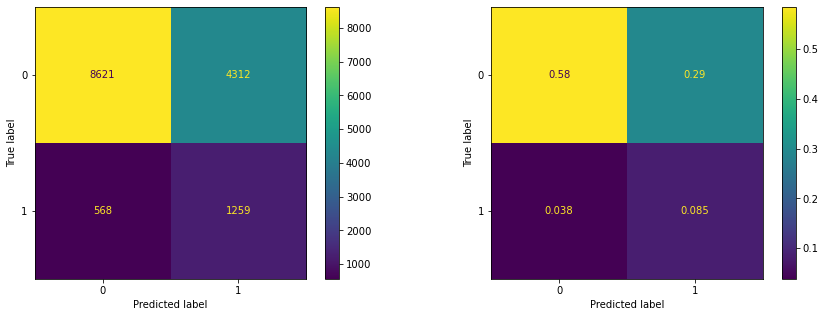

accuracy: 0.669
precision: 0.226
recall: 0.689
f1: 0.34


In [52]:
confusion_matrix(y_test, y_pred, labels=[1, 0])
plot_cmatrix(y_test, y_pred)
print_metrics(y_test, y_pred)

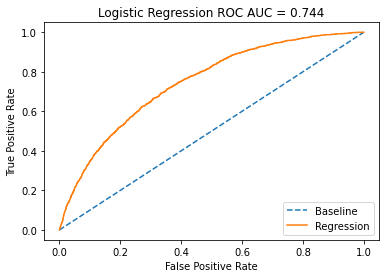

In [53]:
roc_auc(y_test, y_proba)

# Итоговые оценки метрик модели с гиперпараметрами

Метрики recall и f1_score заметно улучшились, теперь модель гораздо лучше определяет дефолтных клиентов. Но при этом в 2 раза упала метрика precision, это говорит о том что мы много хороших клиентов относим к дефолтным. При этом метрика общей точности модели ROC-AUC изменилась лишь на 0.01, значит в целом точность модели осталась примерно такой же, но модель теперь гораздо лучше определяет дефолтных клиентов. Считаю что для банка такая модель подойдет лучше, т.к. правильно определенное большинство дефолтных клиентов сохранит гораздо больше денег, чем мы недополучим из-за невыданного кредита хорошему клиенту.

# Submission

In [54]:
y_proba_test = model.predict_proba(X_df_test)[:, 1]
y_pred_test = model.predict(X_df_test)

submission = df_test[["client_id"]].copy()
submission["default"] = y_proba_test
submission.to_csv("submission.csv", index=False)

In [51]:
submission